# Strategy Details

Cross-stock momentum builds on the asymmetry in lead-lag linkages and the difference between long-run and short-run contemporaneous co-movements. The asymmetry distinguishes cross-stock momentum from factor momentum, and industry momentum is not subsumed by factor momentum. Factor momentum profit is mostly due to the high cross-stock links.

However, the method implemented in the paper is relatively complex. We wonder if just utilizing the cross stock momentum can generate good profit.

In [1]:
# Collect the list of the S&P 500 companies from Wikipedia and save it to a file
import os
import requests
import pandas as pd

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Get the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content
df = pd.read_html(html, header=0)[0]

tickers = df['Symbol'].tolist()

In [2]:
# Load the data from yahoo finance
import os
import yfinance as yf

def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2023-12-31')

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        holder.append(df)
        ticker_with_data.append(symbol)

tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')


Failed to get ticker 'BRK.B' reason: Expecting value: line 1 column 1 (char 0)
BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 2005-01-01 -> 2023-12-31)
GEV: No price data found, symbol may be delisted (1d 2005-01-01 -> 2023-12-31)
SOLV: No price data found, symbol may be delisted (1d 2005-01-01 -> 2023-12-31)


Loaded data for 499 companies


### Adding the factor and monthly return
Assuming the we will open at the monthly open price and will close at the monthly close

In [3]:
# We only need the monthly data, so we will resample the data,
# Open should be the first day of the month, Close should be the last day of the month
# High should be the maximum value of the month, Low should be the minimum value of the month
monthly_data = []
for data in holder:
    df = data.resample('M').agg({
        'date': 'first',
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    df.set_index('date', inplace=True)

    monthly_data.append(df)

del holder

In [4]:
temp = []
for df in monthly_data:
    # Compute the monthly return   
    df['monthly_return'] = df['Close'].pct_change()
    df['intra_month_return'] = (df['Close'] - df['Open']) / df['Open']
    df['next_intra_month_return'] = df['intra_month_return'].shift(-1)
    # Compute the cumulative return
    df['last_1_month_cumulative_return'] = (1 + df['monthly_return']).cumprod()
    df['last_1_month_cumulative_return'] = df['last_1_month_cumulative_return'].shift(1)    
    df['last_2_month_cumulative_return'] = df['last_1_month_cumulative_return'].shift(1)
    temp.append(df)

monthly_data = temp
    

In [5]:
monthly_data[0].head(3)

,Open,High,Low,Close,Volume,monthly_return,intra_month_return,next_intra_month_return,last_1_month_cumulative_return,last_2_month_cumulative_return
date,,,,,,,,,,
2005-01-03 00:00:00-05:00,38.470295,40.029323,37.796112,39.495586,88466685,NaN,0.026652,0.000137,NaN,NaN
2005-02-01 00:00:00-05:00,39.490923,40.722233,38.835472,39.496319,57967609,0.000019,0.000137,0.020727,NaN,NaN
2005-03-01 00:00:00-05:00,39.501024,41.147859,39.298700,40.319752,66145137,0.020848,0.020727,-0.110814,1.000019,NaN


# Regression Analysis

According to the research paper, we use the cumulative returns to calculate 

In [6]:
# Calculate the correlation of each 2 stocks using the last 1 month cumulative return and last 2 month cumulative return 
# Using the data from 2005 - 2020

# Transfer all the data to a single dataframe
last_1_month_cumulative_return_holder = []
last_2_month_cumulative_return_holder = []
for symbol, df in zip(tickers, monthly_data):
    last_1_month_cumulative_return_series = df['last_1_month_cumulative_return'].copy().dropna()
    last_2_month_cumulative_return_series = df['last_2_month_cumulative_return'].copy().dropna()

    last_1_month_cumulative_return_series.name = symbol
    last_2_month_cumulative_return_series.name = symbol

    last_1_month_cumulative_return_holder.append(last_1_month_cumulative_return_series)
    last_2_month_cumulative_return_holder.append(last_2_month_cumulative_return_series)

last_1_month_cumulative_return_df = pd.concat(last_1_month_cumulative_return_holder, axis=1)
last_2_month_cumulative_return_df = pd.concat(last_2_month_cumulative_return_holder, axis=1)

# # If the columns contain any NaN, drop the column
# last_1_month_cumulative_return_df.dropna(axis=1, inplace=True)
# last_2_month_cumulative_return_df.dropna(axis=1, inplace=True)

print(last_1_month_cumulative_return_df.iloc[0:3, 0:3])
print(last_2_month_cumulative_return_df.iloc[0:3, 0:3])



                                MMM       AOS       ABT
date                                                   
2005-03-01 00:00:00-05:00  1.000019  0.969384  1.021546
2005-04-01 00:00:00-05:00  1.020867  1.064921  1.035540
2005-05-02 00:00:00-04:00  0.911025  1.057225  1.098264
                                MMM       AOS       ABT
date                                                   
2005-04-01 00:00:00-05:00  1.000019  0.969384  1.021546
2005-05-02 00:00:00-04:00  1.020867  1.064921  1.035540
2005-06-01 00:00:00-04:00  0.911025  1.057225  1.098264


## Build the correlation matrix

In [7]:
# Calculate the correlation using the last 1 month cumulative return and last 2 month cumulative return and store it to a dataframe
# Use the stock data from 2005 - 2017
correlation_holder = []

for ticker in tickers:
    temp_df = pd.DataFrame()
    temp_df[ticker] = last_1_month_cumulative_return_df[ticker]

    # duplicate the column to the number of tickers so that we can use corrwith later on
    temp_df = pd.concat([temp_df] * len(tickers), axis=1)
    # Change the name of the column to the ticker
    temp_df.columns = tickers

    # Calculate the correlation using corrwith
    correlation_series = temp_df.corrwith(last_2_month_cumulative_return_df, axis=0)
    # Set the correlation_series to the correlation_df as the column
    correlation_holder.append(correlation_series)

In [8]:
correlation_df = pd.concat(correlation_holder, axis=1)
correlation_df.columns = tickers

# Transpose the correlation_df
correlation_df_T = correlation_df.T

Now we have the correlation_df and correlation_df_T

In correlation_df:
- column AAPL, row MMM means the correlation between AAPL and MMM using the last 1 month cumulative return of AAPL and last 2 month cumulative return of MMM
- (MMM, AAPL) = Correlation(AAPL_last_1_month_cumulative_return, MMM_last_2_month_cumulative_return)


In correlation_df_T:
- column AAPL, row MMM means the correlation between AAPL and MMM using the last 2 month cumulative return of AAPL and last 1 month cumulative return of MMM
- (MMM, AAPL) = Correlation(MMM_last_1_month_cumulative_return, AAPL_last_2_month_cumulative_return)

In [9]:
# Get the difference between the correlation_df and correlation_df_T, so that we can know the lead-lag linkage betwe
correlation_diff =  correlation_df_T - correlation_df

Now, in the correlation_diff: 
- If (MMM, AAPL) > 0,  MMM is following AAPL
- If (MMM, AAPL) < 0,  AAPL is following MMM

In [11]:
# Get the pair of stocks that have the highest correlation difference
correlation_diff_selected_pairs = correlation_diff.stack()
correlation_diff_selected_pairs = correlation_diff_selected_pairs[correlation_diff_selected_pairs > 0.1]
#print(correlation_diff_selected_pairs)
# Save the pairs and the correlation into a holder 
pairs = {}
for symbol in tickers:
    pairs[symbol] = []
    
for pair in correlation_diff_selected_pairs.index:
    # Get the left and right pair
    left, right = pair
    pairs[left].append([right, correlation_diff_selected_pairs[pair]])

In [13]:
# Sort the pairs based on the correlation difference
for symbol in tickers:
    pairs[symbol] = sorted(pairs[symbol], key=lambda x: x[1], reverse=True)

# Regression Analysis based on the correlation

As one stock may have multiple leader stocks, we perform the regression analysis based on the leader stock that has the highest correlation difference

In [14]:
# Add the last 2 month cumulative return of the leader stocks to the lagger stocks
for ticker in tickers:
    if len(pairs[ticker]) > 0:
        monthly_data[tickers.index(ticker)]['last_2_month_cumulative_return_' + pairs[ticker][0][0]] = last_2_month_cumulative_return_df[ticker]

In [19]:
monthly_data[tickers.index("MMM")].head(3)

,Open,High,Low,Close,Volume,monthly_return,intra_month_return,next_intra_month_return,last_1_month_cumulative_return,last_2_month_cumulative_return,last_2_month_cumulative_return_KVUE,corrMMM
date,,,,,,,,,,,,
2005-01-03 00:00:00-05:00,38.470295,40.029323,37.796112,39.495586,88466685,NaN,0.026652,0.000137,NaN,NaN,NaN,NaN
2005-02-01 00:00:00-05:00,39.490923,40.722233,38.835472,39.496319,57967609,0.000019,0.000137,0.020727,NaN,NaN,NaN,NaN
2005-03-01 00:00:00-05:00,39.501024,41.147859,39.298700,40.319752,66145137,0.020848,0.020727,-0.110814,1.000019,NaN,NaN,NaN


In [20]:
# Calculate the correlation of each 2 stocks using the last 2 month cumulative return of the leader stocks and last 1 month cumulative return of the lagger stocks on a rolling basis of 3 months
for ticker in tickers:
    if len(pairs[ticker]) > 0:
        monthly_data[tickers.index(ticker)]['corr' + pairs[ticker][0][0]] = monthly_data[tickers.index(ticker)]['last_2_month_cumulative_return_' + pairs[ticker][0][0]].rolling(12).corr(monthly_data[tickers.index(ticker)]['last_1_month_cumulative_return'])



In [21]:
# Build the regression analysis
regression_data = []
for ticker in tickers:
    if len(pairs[ticker]) > 0:
            
        df = pd.DataFrame()
        df['y'] = monthly_data[tickers.index(ticker)]['monthly_return']
        df['corr'+pairs[ticker][0][0]] = monthly_data[tickers.index(ticker)]['corr'+pairs[ticker][0][0]]
    
        regression_data.append(df)
            

In [22]:
# Build the regression model on corr+pair first
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import numpy as np

regression_holder_corr = []
regression_holder_return = []
regression_holder_y = []
for df in regression_data:
    df.dropna(inplace=True)
    # X is the second column
    X_corr = df.iloc[:, 1:2]
    # Set the index of X to be the number of the row
    X_corr.index = np.arange(len(X_corr))
    # Set the column name to be "CORR"
    X_corr.columns = ['CORR']    
    X_return = df.iloc[:, -1:]
    #print(X_return)
    X_return.index = np.arange(len(X_return))
    X_return.columns = ['Corr_RETURN']
    y = df['y']
    # Set the index of y to be the number of the row
    y.index = np.arange(len(y))
    
    regression_holder_corr.append(X_corr)
    regression_holder_return.append(X_return)
    regression_holder_y.append(y)

regression_df = pd.DataFrame()
# Concatenate all the X and y vertically
regression_df_corr = pd.concat(regression_holder_corr,ignore_index=True)
regression_df_return = pd.concat(regression_holder_return,ignore_index=True)
regression_df_y = pd.concat(regression_holder_y,ignore_index=True)

regression_df = pd.concat([regression_df_corr, regression_df_return, regression_df_y], axis=1)

# Fit the regression model for y and CORR
X = sm.add_constant(regression_df['CORR'])
model = OLS(regression_df['y'], X)
result_corr = model.fit()
print(result_corr.summary())

    

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     29.09
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           6.94e-08
Time:                        01:37:17   Log-Likelihood:                 89626.
No. Observations:               93201   AIC:                        -1.792e+05
Df Residuals:                   93199   BIC:                        -1.792e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.001      9.803      0.0

# Cross-stock Momentum using data-driven linkages

Use the stock data from 2018-2023

In [23]:
# Get the stock price from 2005-2017 and stock price from 2018-2023
last_1_month_cumulative_return_df_2005_2017 = last_1_month_cumulative_return_df.loc['2005-01-01':'2017-12-31']
last_1_month_cumulative_return_df_2018_2023 = last_1_month_cumulative_return_df.loc['2018-01-01':'2023-12-31']

last_2_month_cumulative_return_df_2005_2017 = last_2_month_cumulative_return_df.loc['2005-01-01':'2017-12-31']
last_2_month_cumulative_return_df_2018_2023 = last_2_month_cumulative_return_df.loc['2018-01-01':'2023-12-31']

# Get the dataframe containing the next month return from 2005-2017 and 2018-2023
next_intra_month_return_holder = []
intra_month_return_holder = []
for symbol,df in zip(tickers, monthly_data):
    next_intra_month_return_series = df['next_intra_month_return'].copy().dropna()
    next_intra_month_return_series.name = symbol
    intra_month_return_series = df['intra_month_return'].copy().dropna()
    intra_month_return_series.name = symbol

    next_intra_month_return_holder.append(next_intra_month_return_series)
    intra_month_return_holder.append(intra_month_return_series)

next_intra_month_return_df = pd.concat(next_intra_month_return_holder, axis=1)
intra_month_return_df = pd.concat(intra_month_return_holder, axis=1)

next_intra_month_return_df_2005_2017 = next_intra_month_return_df.loc['2005-01-01':'2017-12-31']
next_intra_month_return_df_2018_2023 = next_intra_month_return_df.loc['2018-01-01':'2023-12-31']

intra_month_return_df_2005_2017 = intra_month_return_df.loc['2005-01-01':'2017-12-31']
intra_month_return_df_2018_2023 = intra_month_return_df.loc['2018-01-01':'2023-12-31']





In [24]:
# Build the correlation matrix for the stock price from 2005-2017
correlation_holder_2005_2017 = []
for ticker in tickers:
    temp_df = pd.DataFrame()
    temp_df[ticker] = last_1_month_cumulative_return_df_2005_2017[ticker]

    # duplicate the column to the number of tickers
    temp_df = pd.concat([temp_df] * len(tickers), axis=1)
    # Change the name of the column to the ticker
    #print(ticker)
    temp_df.columns = tickers

    # Calculate the correlation
    correlation_series = temp_df.corrwith(last_2_month_cumulative_return_df_2005_2017, axis=0)
    # Set the correlation_series to the correlation_df as the column
    correlation_holder_2005_2017.append(correlation_series)

correlation_df_2005_2017 = pd.concat(correlation_holder_2005_2017, axis=1)
correlation_df_2005_2017.columns = tickers

# Transpose the correlation_df
correlation_df_T_2005_2017 = correlation_df_2005_2017.T

# Get the difference between the correlation_df and correlation_df_T, so that we can know the lead-lag linkage betwe
correlation_diff_2005_2017 =  correlation_df_T_2005_2017 - correlation_df_2005_2017

In [27]:
# Get the pair of stocks that have lead-lag linkage and store the paris into a holder
# Get the pair of stocks that have the highest correlation difference
correlation_diff_selected_pairs_2005_2017 = correlation_diff_2005_2017.stack()
correlation_diff_selected_pairs_2005_2017 = correlation_diff_selected_pairs_2005_2017[correlation_diff_selected_pairs_2005_2017 > 0.1]

linkage_2005_2017 = {}
for symbol in tickers:
    linkage_2005_2017[symbol] = []

for pair in correlation_diff_selected_pairs_2005_2017.index:
    # Get the left and right pair
    left, right = pair
    #print(left, right, correlation_diff_selected_pairs_2005_2017[pair])
    linkage_2005_2017[left].append([right, correlation_diff_selected_pairs_2005_2017[pair]])

# Sort the pairs based on the correlation difference
for symbol in tickers:
    linkage_2005_2017[symbol] = sorted(linkage_2005_2017[symbol], key=lambda x: x[1], reverse=True)

In [28]:
linkage_2005_2017['MMM']

[['HWM', 0.23007886404415998], ['IR', 0.17020141402388766]]

In [31]:
# Create a new dataframe that stores the stock price from 2018-2023 and the stock price from 2018-2023 of the leader stocks 
prediction_matrix_2018_2023_holder = []

for data in monthly_data:
    df = data.loc['2018-01-01':'2023-12-31'].copy()
    # keep the intra_month_return and next_intra_month_return only
    df = df[['intra_month_return', 'next_intra_month_return']]
    prediction_matrix_2018_2023_holder.append(df)

temp = []
for ticker in tickers:
    if len(linkage_2005_2017[ticker]) > 0:
        df = prediction_matrix_2018_2023_holder[tickers.index(ticker)].copy()
        for leader_stock in linkage_2005_2017[ticker]:
            df['intra_month_return' + leader_stock[0]] = prediction_matrix_2018_2023_holder[tickers.index(leader_stock[0])]['intra_month_return']
        
        df['predicted_next_month_return'] = sum([df['intra_month_return' + pair[0]] for pair in linkage_2005_2017[ticker]]) / len(linkage_2005_2017[ticker])
        temp.append(df)
    prediction_matrix_2018_2023_holder[tickers.index(ticker)]['intra_month_return'] = intra_month_return_df_2018_2023[ticker]

    
prediction_matrix_2018_2023_holder = temp


In [32]:
prediction_matrix_2018_2023_holder[0]

,intra_month_return,next_intra_month_return,intra_month_returnHWM,intra_month_returnIR,predicted_next_month_return
date,,,,,
2018-01-02 00:00:00-05:00,0.062431,-0.042601,0.100696,0.011407,0.056051
2018-02-01 00:00:00-05:00,-0.042601,-0.070421,-0.180168,-0.088034,-0.134101
2018-03-01 00:00:00-05:00,-0.070421,-0.108507,-0.058054,-0.042148,-0.050101
2018-04-02 00:00:00-04:00,-0.108507,0.023444,-0.223627,0.041146,-0.091241
2018-05-01 00:00:00-04:00,0.023444,-0.010214,-0.016592,0.081962,0.032685
...,...,...,...,...,...
2023-08-01 00:00:00-04:00,-0.029011,-0.127493,-0.004399,0.075048,0.035325
2023-09-01 00:00:00-04:00,-0.127493,-0.018349,-0.073703,-0.089584,-0.081644
2023-10-02 00:00:00-04:00,-0.018349,0.103872,-0.040261,-0.045462,-0.042861


## Long & Short Strategy

In [34]:
for df in prediction_matrix_2018_2023_holder:
    # Build the trading signal based on the predicted_next_month_return
    df['signal'] = np.where(df['predicted_next_month_return'] > 0, 1, -1)
    # Build the trading return
    df['trading_return'] = df['signal'] * df['next_intra_month_return']

# Convert the trading return to dataframe 
trading_return_holder = []
for ticker, df in zip(tickers,prediction_matrix_2018_2023_holder):
    trading_return = df['trading_return'].copy()
    trading_return.name = ticker
    trading_return_holder.append(trading_return)

trading_return_df = pd.concat(trading_return_holder, axis=1)

# Build an equal weighted portfolio
portfolio = trading_return_df.mean(axis=1)
portfolio_cumulative_return = (1 + portfolio).cumprod()


In [39]:
portfolio_cumulative_return

date
2018-01-02 00:00:00-05:00    0.971511
2018-02-01 00:00:00-05:00    0.973092
2018-03-01 00:00:00-05:00    0.976938
2018-04-02 00:00:00-04:00    0.975294
2018-05-01 00:00:00-04:00    0.987296
                               ...   
2023-08-01 00:00:00-04:00    0.660283
2023-09-01 00:00:00-04:00    0.680224
2023-10-02 00:00:00-04:00    0.616443
2023-11-01 00:00:00-04:00    0.660401
2023-12-01 00:00:00-05:00         NaN
Length: 72, dtype: float64

In [55]:
# Get the cumulative return of each stocks from 2018-2023 and store it to a list
cumulative_return_2018_2023 = []
for df in prediction_matrix_2018_2023_holder:
    df['cumulative_return'] = (1 + df['trading_return']).cumprod()
    #print(df['cumulative_return'].iloc[-2])
    cumulative_return_2018_2023.append(df['cumulative_return'].iloc[-2])

## Long-Only

In [48]:
for df in prediction_matrix_2018_2023_holder:
    # Build the trading signal based on the predicted_next_month_return
    df['signal_long_only'] = np.where(df['predicted_next_month_return'] > 0, 1, 0)
    # Build the trading return
    df['trading_return_long_only'] = df['signal_long_only'] * df['next_intra_month_return']

# Convert the trading return to dataframe 
long_only_trading_return_holder = []
for ticker, df in zip(tickers, prediction_matrix_2018_2023_holder):
    long_only_trading_return = df['trading_return_long_only']
    long_only_trading_return.name = ticker
    long_only_trading_return_holder.append(long_only_trading_return)

long_only_trading_return_df = pd.concat(long_only_trading_return_holder, axis=1)

# Build an equal weighted portfolio
portfolio_long_only = long_only_trading_return_df.mean(axis=1)
portfolio_cumulative_return_long_only = (1 + portfolio_long_only).cumprod()


In [53]:
# Calculate the cumulative return of each stocks from 2018-2023
cumulative_return_2018_2023_long_only = []
for df in prediction_matrix_2018_2023_holder:
    df['cumulative_return_long_only'] = (1 + df['trading_return_long_only']).cumprod()
    cumulative_return_2018_2023_long_only.append(df['cumulative_return_long_only'].iloc[-2])

# Result

In [51]:
# Calculate the sharpe ratio of these 2 portfolios
sharpe_ratio = portfolio.mean() / portfolio.std() * np.sqrt(12)
sharpe_ratio_long_only = portfolio_long_only.mean() / portfolio_long_only.std() * np.sqrt(12)
print(f'Sharpe ratio of the portfolio is {sharpe_ratio}', '; ',f'Sharpe ratio of the long only portfolio is {sharpe_ratio_long_only}')

# Calculate the VaR of these 2 portfolios
VaR_95 = portfolio.quantile(0.05)
VaR_95_long_only = portfolio_long_only.quantile(0.05)
print(f'VaR of the portfolio is {VaR_95}', '; ' ,f'VaR of the long only portfolio is {VaR_95_long_only}')

# Calculate the Annualized Return of these 2 portfolios
Annualized_Return = portfolio.mean() * 12
Annualized_Return_long_only = portfolio_long_only.mean() * 12
print(f'Annualized Return of the portfolio is {Annualized_Return}', '; ' ,f'Annualized Return of the long only portfolio is {Annualized_Return_long_only}')



Sharpe ratio of the portfolio is -0.3327207899167109 ;  Sharpe ratio of the long only portfolio is 0.3753774395775242
VaR of the portfolio is -0.09033691418709533 ;  VaR of the long only portfolio is -0.05035388010189022
Annualized Return of the portfolio is -0.055734054835622826 ;  Annualized Return of the long only portfolio is 0.03570048681606856


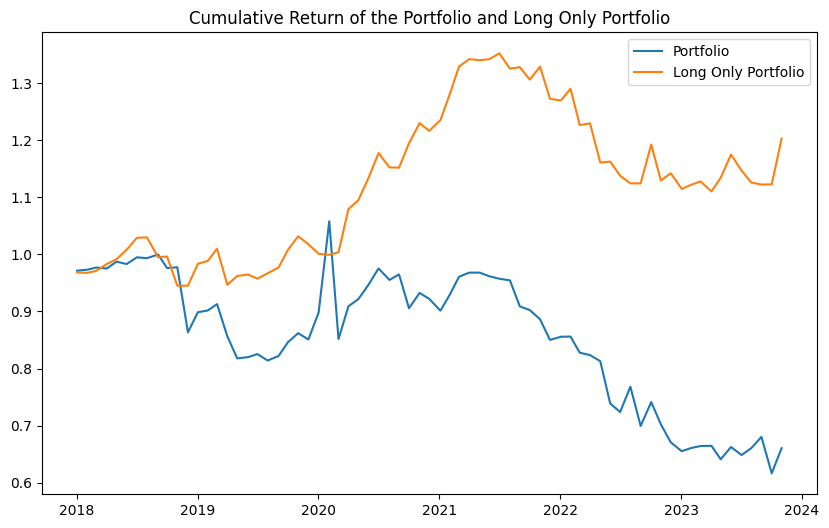

In [58]:
# Draw the line chart of the cumulative return of the portfolio and the long only portfolio
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cumulative_return, label='Portfolio')
plt.plot(portfolio_cumulative_return_long_only, label='Long Only Portfolio')
plt.legend()
plt.title('Cumulative Return of the Portfolio and Long Only Portfolio')
plt.show()